### Stock Analysis Using LSTM And PyTorch

In [52]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [37]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/g5XM0-gTrOquyZcBxcJAfw/StockData.csv")
df.drop(['Unnamed: 0'], axis=1, inplace = True)
df.head()

,Date,Open,High,Low,Close
0,2018-03-27,173.68,175.15,166.92,168.340
1,2018-03-26,168.07,173.10,166.44,172.770
2,2018-03-23,168.39,169.92,164.94,164.940
3,2018-03-22,170.00,172.68,168.60,168.845
4,2018-03-21,175.04,175.09,171.26,171.270


In [38]:
stock_data = df
stock_data['Data'] = pd.to_datetime(df.Date)
print("Information about the dataset", end= "\n")
print(stock_data.info())

Information about the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9400 non-null   object        
 1   Open    9400 non-null   float64       
 2   High    9400 non-null   float64       
 3   Low     9400 non-null   float64       
 4   Close   9400 non-null   float64       
 5   Data    9400 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 440.8+ KB
None


In [40]:
stock_data = stock_data.sort_values(by="Date")
print(stock_data.head())

            Date   Open   High    Low  Close       Data
9399  1980-12-12  28.75  28.87  28.75  28.75 1980-12-12
9398  1980-12-15  27.38  27.38  27.25  27.25 1980-12-15
9397  1980-12-16  25.37  25.37  25.25  25.25 1980-12-16
9396  1980-12-17  25.87  26.00  25.87  25.87 1980-12-17
9395  1980-12-18  26.63  26.75  26.63  26.63 1980-12-18


In [41]:
price = stock_data[['High', 'Low', 'Open', 'Close']]
print(price[:5])

       High    Low   Open  Close
9399  28.87  28.75  28.75  28.75
9398  27.38  27.25  27.38  27.25
9397  25.37  25.25  25.37  25.25
9396  26.00  25.87  25.87  25.87
9395  26.75  26.63  26.63  26.63


In [42]:
scaler = MinMaxScaler()
scaler.fit(price.values)

MinMaxScaler()

##### Create training and testing sets

In [43]:
train_window = 7

def create_in_out_sequences(price, tw):
    inout_seq = []
    L = len(price)
    print("Length = ", L)

    scaled_price = scaler.transform(price)

    for i in range(L-tw):
        train_seq = scaled_price[i:i+tw]
        train_label = scaled_price[i+tw:i+tw+1][0][3]
        inout_seq.append((train_seq ,train_label))
    
    data = inout_seq
    print("Size of data: ", len(data))
    
    test_set_size = 20
    train_set_size = len(data) - (test_set_size)
    print("Train set size: ", train_set_size)
    print("Test set size: ", test_set_size)

    train = data[:train_set_size]
    test = data[train_set_size:] 
    train = train[:-(tw-1)]
    return train, test

train, test = create_in_out_sequences(price.values, train_window)

Length =  9400
Size of data:  9393
Train set size:  9373
Test set size:  20


In [44]:
print(test[0])
print(train[-1])

(array([[0.23589596, 0.23348389, 0.23324509, 0.23358414],
       [0.23508898, 0.23297559, 0.23279666, 0.2327449 ],
       [0.23488724, 0.23238015, 0.23392498, 0.23161626],
       [0.23464227, 0.23339675, 0.23243501, 0.23383013],
       [0.23709201, 0.23605443, 0.2351401 , 0.23810592],
       [0.24248145, 0.23993203, 0.23901691, 0.24304732],
       [0.24405217, 0.24276399, 0.24299498, 0.24220807]]), np.float64(0.2418173925625814))
(array([[0.21943944, 0.21503769, 0.21982815, 0.21493272],
       [0.21598098, 0.20917263, 0.21578498, 0.20882651],
       [0.21149939, 0.20221619, 0.21112702, 0.20976704],
       [0.22014554, 0.2127743 , 0.21319562, 0.21951961],
       [0.22138483, 0.21878676, 0.21818629, 0.22187817],
       [0.22540529, 0.22057307, 0.21977028, 0.22626248],
       [0.23340298, 0.22946106, 0.22952741, 0.23439444]]), np.float64(0.23358414122413543))


##### Define LSTM and Forward Method

In [45]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                       torch.zeros(1,1,self.hidden_layer_size))
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [46]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##### Training the Model

In [47]:
epochs = 5
for i in tqdm(range(epochs)):
    epoch_loss = 0
    for seq, labels in train:
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()
        y_pred = model(seq)
        labels = labels.view(1)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()
    
    average_loss = epoch_loss/len(train)
    print(f'epoch: {i:3} loss: {single_loss.item():10f}')

epoch:   0 loss:   0.000065


epoch:   1 loss:   0.000026


epoch:   2 loss:   0.000000


epoch:   3 loss:   0.000000


100%|██████████| 5/5 [01:00<00:00, 12.05s/it]

epoch:   4 loss:   0.000001


In [48]:
model.eval()
actual = []
pred = []

for seq, labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        pred.append(model(seq).item())

actual = np.array(actual)
pred = np.array(pred) 

In [49]:
pred = torch.from_numpy(pred).type(torch.Tensor)
actual = torch.from_numpy(actual).type(torch.Tensor)

print(pred)
print(actual)

tensor([0.2383, 0.2365, 0.2309, 0.2289, 0.2326, 0.2354, 0.2317, 0.2333, 0.2378,
        0.2409, 0.2392, 0.2346, 0.2341, 0.2340, 0.2308, 0.2313, 0.2278, 0.2242,
        0.2205, 0.2286])
tensor([0.2418, 0.2373, 0.2391, 0.2399, 0.2397, 0.2373, 0.2401, 0.2445, 0.2470,
        0.2445, 0.2423, 0.2426, 0.2417, 0.2377, 0.2377, 0.2319, 0.2284, 0.2227,
        0.2341, 0.2277])


In [51]:
new_pred = scaler.inverse_transform(np.c_[np.zeros(20), np.zeros(20), np.zeros(20), np.array(pred)])
print(new_pred[:3])
new_actual = scaler.inverse_transform(np.c_[np.zeros(20), np.zeros(20), np.zeros(20), np.array(actual)])
print(new_actual[:3])

[[ 11.12        11.          11.12       175.68276272]
 [ 11.12        11.          11.12       174.41318095]
 [ 11.12        11.          11.12       170.60436356]]
[[ 11.12        11.          11.12       178.12000504]
 [ 11.12        11.          11.12       175.00000285]
 [ 11.12        11.          11.12       176.20999928]]


/var/folders/57/lkjj_8_947v2yx8610cdh01r0000gn/T/ipykernel_69057/3928832231.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  new_pred = scaler.inverse_transform(np.c_[np.zeros(20), np.zeros(20), np.zeros(20), np.array(pred)])
/var/folders/57/lkjj_8_947v2yx8610cdh01r0000gn/T/ipykernel_69057/3928832231.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  new_actual = scaler.inverse_transform(np.c_[np.zeros(20), np.zeros(20), np.zeros(20), np.array(actual)])


##### Evaluate the Model

In [53]:
mae = mean_absolute_error(new_actual, new_pred)
print("Mean Absolute Error: ", mae)

rmse = np.sqrt(mean_squared_error(new_actual, new_pred))
print("Root Mean Squared Error: ", rmse)

Mean Absolute Error:  0.9617816668003784
Root Mean Squared Error:  2.3556040240953795


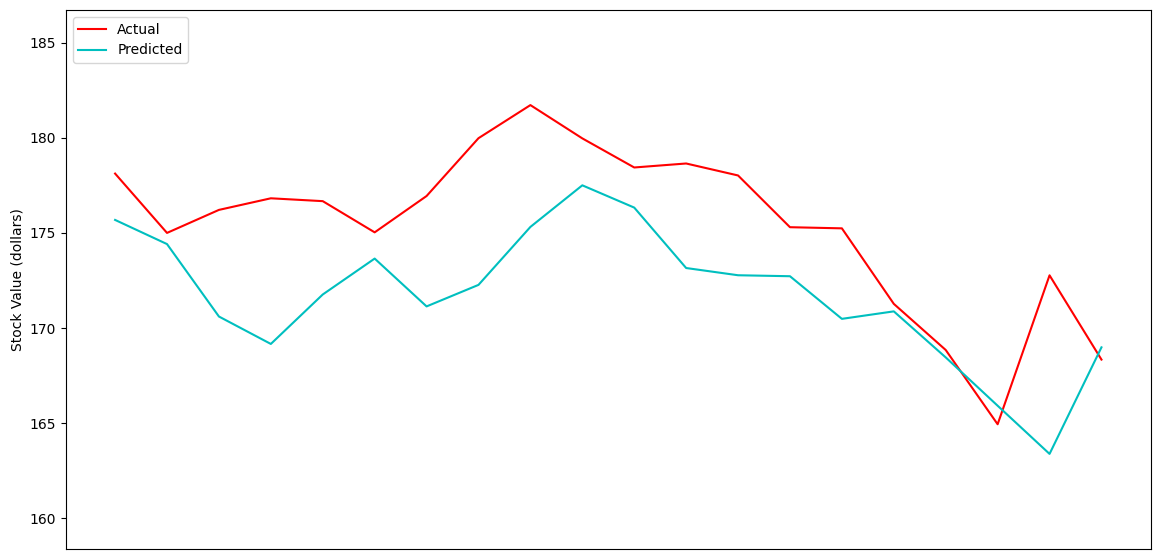

In [58]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(new_actual[:,3], 'r-', label='Actual')
ax.plot(new_pred[:,3], 'c-', label='Predicted')

ax.set_ylabel('Stock Value (dollars)')

ax.set_ylim(min(min(new_actual[:,3]), min(new_pred[:,3]))-5, max(max(new_actual[:,3]), max(new_pred[:,3]))+5)
plt.xticks([])

ax.legend(loc="upper left")

plt.show()

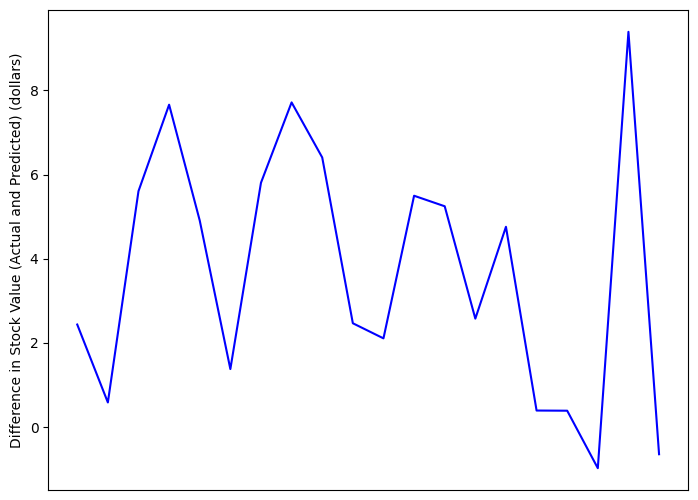

In [59]:
difference = new_actual - new_pred
fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:, 3], 'b')
diffGraph.set_ylabel('Difference in Stock Value (Actual and Predicted) (dollars)')
plt.xticks([])
plt.show()